In [1]:
# 종속변수

# 1) 향후 10분 후 종가 기준 리턴: returns
# 2) bid price 및 ask price 기준 10분 동안 실질적 리턴: returns_next10m
# 3) 10분 동안 realized volatility: realized_vol_next10m


### 1. Initialization

In [2]:
# 필요 라이브러리 import

# Pytorch
import torch
import torch.optim as optim
import torch.nn as nn

# Dataset 관련
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
import sequence as sq # 사용자 정의 함수 불러오기

# 성능 평가 관련
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import confusion_matrix
from collections import Counter

# Visualization 관련
import matplotlib.pyplot as plt
import seaborn as sns

# 하이퍼파라미터 튜닝
import optuna
from optuna.pruners import MedianPruner
from sklearn.model_selection import TimeSeriesSplit

# 운영체제 관련
import platform

'''
딥러닝 학습을 진행할 때, 가중치를 임의의 값으로 초기화하여 학습을 수행하는 데, 
실험을 동일하게 진행하기 위해서는 난수를 동일하게 생성해야 한다.
Pytorch에서 random seed를 고정하기 위해 manual_seed를 사용한다.
'''

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

# 운영체제별 device 설정
os_name = platform.system()
if os_name == 'Windows':
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(f"이 PC는 윈도우 운영 체제입니다: {device} is available")
elif os_name == 'Darwin':
    device = torch.device("mps" if torch.backends.mps.is_available else "cpu")
    print(f"이 PC는 맥(OS X) 운영 체제입니다: {device} is available")
else:
    print(f"이 PC는 다른 운영 체제입니다: {os_name}")


이 PC는 맥(OS X) 운영 체제입니다: mps is available


/opt/homebrew/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 2. Data Preprocessing

In [3]:
import pickle

# 불러오기
file_path = '../../data/'
seq_len = 20

with open(f'{file_path}X_train_seq_{seq_len}.pkl', 'rb') as file:
     X_train_seq= pickle.load(file)

with open(f'{file_path}X_val_seq_{seq_len}.pkl', 'rb') as file:
     X_val_seq= pickle.load(file)

with open(f'{file_path}X_test_seq_{seq_len}.pkl', 'rb') as file:
     X_test_seq= pickle.load(file)

with open(f'{file_path}y_train_seq_{seq_len}.pkl', 'rb') as file:
     y_train_seq= pickle.load(file)

with open(f'{file_path}y_val_seq_{seq_len}.pkl', 'rb') as file:
     y_val_seq= pickle.load(file)

with open(f'{file_path}y_test_seq_{seq_len}.pkl', 'rb') as file:
     y_test_seq= pickle.load(file)

print('Train Size:', X_train_seq.size(), y_train_seq.size())
print('Valid Size:', X_val_seq.size(), y_val_seq.size())
print('Test Size:', X_test_seq.size(), y_test_seq.size())

Train Size: torch.Size([66646, 20, 77]) torch.Size([66646, 1])
Valid Size: torch.Size([22215, 20, 77]) torch.Size([22215, 1])
Test Size: torch.Size([22216, 20, 77]) torch.Size([22216, 1])


In [4]:
# Dataset과 DataLoader를 이용해 배치 데이터로 만든다.
train = torch.utils.data.TensorDataset(X_train_seq, y_train_seq)
valid = torch.utils.data.TensorDataset(X_val_seq, y_val_seq)
test = torch.utils.data.TensorDataset(X_test_seq, y_test_seq)
batch_size = 128 # 32, 64, 128
train_loader =  torch.utils.data.DataLoader(dataset=train, batch_size=batch_size, shuffle=False, drop_last=True) # 시계열 데이터기에 shuffle X, 마지막 batch 버림
valid_loader = torch.utils.data.DataLoader(dataset=valid, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=test, batch_size=batch_size, shuffle=False)


In [5]:
# 모델 정의
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, device):
        super(LSTM, self).__init__()
        self.device = device
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        # 선형 층의 입력 크기 계산이 필요. 예시에서는 간단히 hidden_size를 사용.
        # sequence_length와의 관계를 정확히 계산하여 적용해야 함.
        self.fc = nn.Linear(hidden_size, 1)  # 출력 크기를 1로 설정
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(self.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(self.device)
        out, _ = self.lstm(x, (h0, c0))
        out = out[:, -1, :]  # 마지막 시퀀스의 출력만 사용
        out = self.fc(out)
        out = torch.sigmoid(out)  # 시그모이드 활성화 함수 적용
        return out


In [6]:
# 하이퍼 파라미터 정의
input_size = 77 # feature 개수
num_layers = 2 # 은닉층의 개수
hidden_size = 256 # 은닉 상태를 저장하는 벡터의 크기

In [7]:
# 모델 불러오기
model = LSTM(input_size=input_size,
             hidden_size=hidden_size,
             num_layers=num_layers,
             device=device).to(device)

In [8]:
# # 학습1: valid를 이용한 과적합 방지 epochs 찾기

# # 학습과 검증 손실을 저장할 리스트 초기화
# train_losses = []
# valid_losses = []

# # # 손실 함수와 옵티마이저 정의
# criterion = nn.BCEWithLogitsLoss() # 시그모이드 활성화 함수가 내장되어 있음. 모델의 마지막 레이어에서 시그모이드 함수 별도 적용할 필요X
# #criterion = nn.BCELoss() # 모델 출력이 시그모이드 활성화 함수를 거쳐 확률로 변환된 후의 값을 입력으로 받음. 입력 값은 0과 1사이의 확률 값.
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# num_epochs = 70

# # 검증 데이터에 대한 모델 성능 평가 함수 정의
# def evaluate(model, criterion, dataloader):
#     model.eval()  # 모델을 평가 모드로 설정
#     total_loss = 0.0
    
#     with torch.no_grad():
#         for batch_features, batch_targets in dataloader:
#             # 배치를 GPU로 전송
#             batch_features, batch_targets = batch_features.to(device), batch_targets.to(device)
            
#             # 모델에 대한 순전파 및 손실 계산
#             outputs = model(batch_features)
#             loss = criterion(outputs, batch_targets)
            
#             total_loss += loss.item()
    
#     return total_loss / len(dataloader.dataset)  # 평균 손실 반환

# # 학습 루프
# for epoch in range(num_epochs):
#     model.train()  # 모델을 학습 모드로 설정
#     total_loss = 0.0
    
#     for batch_features, batch_targets in train_loader:
#         # 배치를 GPU로 전송
#         batch_features, batch_targets = batch_features.to(device), batch_targets.to(device)
        
#         # 모델에 대한 순전파 및 손실 계산
#         optimizer.zero_grad()
#         outputs = model(batch_features)
#         loss = criterion(outputs, batch_targets)
        
#         # 역전파 및 최적화
#         loss.backward()
#         optimizer.step()
        
#         total_loss += loss.item()
    
#     # 에폭마다 학습 손실 기록
#     train_loss = total_loss / len(train_loader.dataset)
#     train_losses.append(train_loss)
    
#     # 검증 데이터에 대한 손실 계산 및 기록
#     valid_loss = evaluate(model, criterion, test_loader)
#     valid_losses.append(valid_loss)
    
#     # 에폭마다 손실 출력
#     print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss}, Valid Loss: {valid_loss}')

# # 손실 함수 시각화
# plt.plot(train_losses, label='Train Loss')
# plt.plot(valid_losses, label='Valid Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()


In [9]:

'''
학습2: train data만 가지고 학습
이미 학습1 코드에서 모델이 학습을 수행하였으므로
학습2 코드 실행 전 재시작 -> 학습1 코드 실행 X -> 학습2 코드 실행(정해진 epochs만 학습)
'''

# 손실 함수와 옵티마이저 정의
criterion = nn.BCEWithLogitsLoss()
#criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

batch_size = 64
train_loader =  DataLoader(dataset=train, batch_size=batch_size, shuffle=False, drop_last=True) # 시계열 데이터기에 shuffle X, 마지막 batch 버림
valid_loader = DataLoader(dataset=valid, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(dataset=test, batch_size=batch_size, shuffle=False)

num_epochs = 50 # train, valid loss를 ㄴ기준으로 과적합되기 전 epochs

# 학습 루프
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    
    for batch_features, batch_targets in train_loader:
        # 배치를 GPU로 전송
        batch_features, batch_targets = batch_features.to(device), batch_targets.to(device)
        
        # 모델에 대한 순전파 및 손실 계산
        optimizer.zero_grad()
        outputs = model(batch_features)
        loss = criterion(outputs, batch_targets)
        
        # 역전파 및 최적화
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    # 에폭마다 손실 출력
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {total_loss}')


Epoch 1/50, Loss: 722.3724625706673
Epoch 2/50, Loss: 721.5669683814049
Epoch 3/50, Loss: 698.2769053578377
Epoch 4/50, Loss: 643.4666610360146
Epoch 5/50, Loss: 638.3594518005848
Epoch 6/50, Loss: 637.3389291167259
Epoch 7/50, Loss: 634.9513037204742
Epoch 8/50, Loss: 634.1512435674667
Epoch 9/50, Loss: 633.0322903096676
Epoch 10/50, Loss: 632.4605115950108
Epoch 11/50, Loss: 630.9793422818184
Epoch 12/50, Loss: 629.8920155465603
Epoch 13/50, Loss: 628.18048620224
Epoch 14/50, Loss: 626.8064841330051
Epoch 15/50, Loss: 625.2789653241634
Epoch 16/50, Loss: 623.814505815506
Epoch 17/50, Loss: 623.5514959692955
Epoch 18/50, Loss: 621.0875818729401
Epoch 19/50, Loss: 620.4110025465488
Epoch 20/50, Loss: 618.4399107694626
Epoch 21/50, Loss: 616.9837774038315
Epoch 22/50, Loss: 614.6863905787468
Epoch 23/50, Loss: 614.1116815209389
Epoch 24/50, Loss: 612.6358650624752
Epoch 25/50, Loss: 612.1830285489559
Epoch 26/50, Loss: 610.5221828818321
Epoch 27/50, Loss: 608.4714848995209
Epoch 28/50, 

Data Imbalance: Counter({0.0: 11343, 1.0: 10873})
Accuracy: 0.4894
Precision: 0.4894
Recall: 1.0
F1 Score: 0.6572


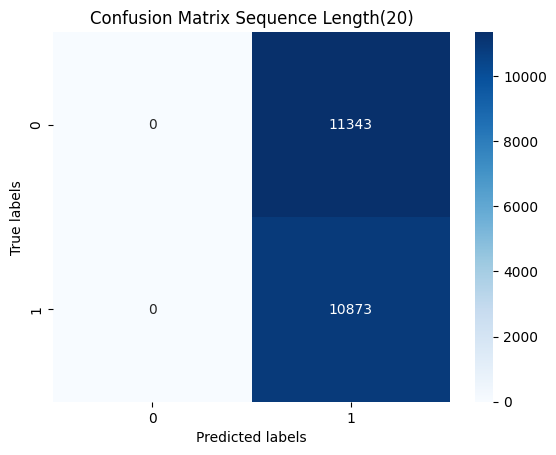

In [10]:
# 테스트 데이터 예측
model.eval()  # 모델을 평가 모드로 설정
y_true = []
y_pred = []
with torch.no_grad():
    for x_batch, labels in test_loader:
        x_batch = x_batch.to(device)
        outputs = model(x_batch)

        # 로그 오즈를 확률로 변환
        probs = torch.sigmoid(outputs).squeeze()

        # 확률을 기준으로 0.5 이상이면 1, 미만이면 0으로 예측
        preds = torch.round(probs).cpu().numpy()
        y_true.extend(labels.squeeze().cpu().numpy())
        y_pred.extend(preds)

# 성능 지표 계산
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

# 결과 출력
print(f'Data Imbalance: {Counter(y_true)}')
print(f'Accuracy: {accuracy.round(4)}')
print(f'Precision: {precision.round(4)}')
print(f'Recall: {recall.round(4)}')
print(f'F1 Score: {f1.round(4)}')

# 혼동 행렬 출력
conf_mat = confusion_matrix(y_true, y_pred)
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title(f'Confusion Matrix Sequence Length({seq_len})')
plt.show()